# Ultimate Data Science Challenge
## Springboard
### Federico Di Martino

In [1]:
## Setup
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(123456789)
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import time

## Part 1 ‑ Exploratory data analysis

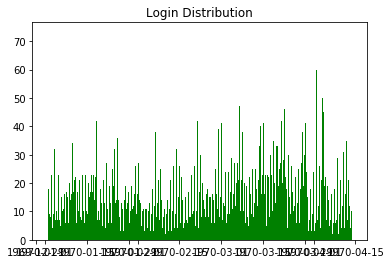

In [4]:
## Part 1
## Load in data
logins = pd.read_json('logins.json')


## Aggregate log in times
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins = logins.set_index('login_time')
logins_15 = logins.resample('15Min').size()


## Plot
plt.title('Login Distribution')
plt.bar(logins_15.index,logins_15.values,width=0.1,edgecolor='None', color = 'green')
plt.show()


Here we can see that logins cycle daily with peaks and troughs.


## Part 2 - Experiment and metrics design

2.1
The key measure of success for this experiment would be the average ratio per
driver of Metropolis rides : Gotham rides. The objective is to encourage driver partners to be available in both cities so if succesful the ratio would be closer to 1:1 than before.
In the code this can be expressed by having a feature counting each gotham ride as a 1 and each metropolis ride as 0. With the target being 0.5.


2.2
a. Randomly select about half of the drivers to be in this experiment and keep the other half working as before as a control group. Run the toll reiumburse experiment for a long enough length of time to reduce random fluctuation in results.
b. T-test.
c. If the ratio feature for the experimental group is significantly closer to 0.5 than that of the control group, then the experiment is a success. It would be recommended to look at how other factors that experiment is not designed for change as well, to avoid unfortunate side effects. For example check that revenue and driver retention have not decreased for the experimental group.

## Part 3 - Predictive Modelling

In [5]:
## Cleaning

## Load in data
with open('ultimate_data_challenge.json') as path:
    udc = json.load(path)       ## list of dicts

## Convert udc into df
udc_df = pd.DataFrame(udc)    

## Drop any row with missing values
udc_df = udc_df.dropna()

## Convert strongs into datetime
udc_df.last_trip_date = [datetime.strptime(i, '%Y-%m-%d') for i in udc_df.last_trip_date]
udc_df.signup_date = [datetime.strptime(i, '%Y-%m-%d') for i in udc_df.signup_date]

# calculate latest date (latest last trip date)
latest_date = max(udc_df.last_trip_date)

# Setup 30 day timedelta
delta = pd.Timedelta('30 days')

## Set up target feature
## Create binary feauture where active = True, inactive = False
udc_df['IsActive']= latest_date - udc_df.last_trip_date <= delta

## EDA
print('There are' ,udc_df.IsActive.sum()/len(udc_df),'% active users.')

## Feature selection: will use all features with categoricals turned into dummy variables
udc_df['IsAndroid'] = udc_df['phone'].map(lambda x: 1 if x=='Android' else 0)
udc_df['IsIphone'] = udc_df['phone'].map(lambda x: 1 if x=='iPhone' else 0)
udc_df['IsKings'] = udc_df['city'].map(lambda x: 1 if x=="King's Landing" else 0)
udc_df['IsAstapor'] = udc_df['city'].map(lambda x: 1 if x=='Astapor' else 0)
udc_df['IsWinter'] = udc_df['city'].map(lambda x: 1 if x=='Winterfell' else 0)
udc_df['IsUBU']=udc_df['ultimate_black_user'].map(lambda x: 1 if x else 0)

selected_df = udc_df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver','avg_surge','surge_pct', 'trips_in_first_30_days', 'weekday_pct',     'IsAndroid', 'IsIphone', 'IsKings', 'IsAstapor', 'IsWinter', 'IsUBU','IsActive']]

# Calculate correlations
corr = selected_df.corr()

# Visualise correlation matrix
corr.style.background_gradient(cmap='coolwarm', axis = None).set_precision(2)


# 3.2

## Predictive model


## Set up data and target and split into training and test sets
X = selected_df.loc[:, selected_df.columns != 'IsActive']
y = selected_df.iloc[:,13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 123456789)


# First try a variety of methods and see which ones perform better
# Create list of methods to try
methods = [] # Generate empty list and then append name and function
methods.append(('KNN', KNeighborsClassifier()))
methods.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
methods.append(('DT', DecisionTreeClassifier()))
methods.append(('RF', RandomForestClassifier(n_estimators = 100)))
methods.append(('BC', BaggingClassifier()))

# Function to build and test models from list of methods assigned
def model_tester(methods):
    results = []
    names = []
    for name, method in methods:
        start = time.time()
        end = time.time()
        kf = KFold(n_splits=10, random_state=123456789)
        cv_results = cross_val_score(method, X_train, y_train, cv= kf, scoring='accuracy')
        end = time.time()
        time_elapsed = end - start
        results.append(cv_results)
        
        names.append(name)
        print('%s Accuracy: Mean %f StD (%f) Time: %f' % (name, cv_results.mean(), cv_results.std(), time_elapsed))

model_tester(methods)

## Choose RF because higher accuracy, not slowest

## Tune the RF hyperparameters
## What hyperparameters are there?
RF = RandomForestClassifier(n_estimators = 100,random_state=123456789) 
print(RF.get_params())

# Will tune n_estimators and max_depth,

# Total number of trees in the random forest
n_estimators = [int(i) for i in np.linspace(100, 100, num=10 ) ]  # has to be integers

# Maximum number of levels in each tree
max_depth = [int(i) for i in np.linspace(10, 90, num = 9) ]
max_depth = np.append(max_depth,None) ## 'None' means no arbitrary maximum




## Create hyperparameter grid
hyper_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

## instantiate grid search
grid_search = GridSearchCV(estimator = RF, param_grid = hyper_grid, 
                          cv = 5) # 5 fold

# fit to data
grid_search.fit(X_train, y_train)

## See which hyper-parameters are best
print(grid_search.best_params_)
# grid_search.best_estimator_

## Use best model on test set and let's see our results!

rf = RandomForestClassifier(n_estimators = 100, max_depth=10 ,random_state=123456789) 
rf.fit(X_train, y_train)
#print('Accuracy: {}'.format(rf.score(X_test , y_test)))

rf_predict = rf.predict(X_test)




print ( 'Accuracy:', accuracy_score(y_test, rf_predict))
print ('F1 score:', f1_score(y_test, rf_predict))
print ('Recall:', recall_score(y_test, rf_predict))
print ('Precision:', precision_score(y_test,rf_predict))
print ('\n clasification report:\n', classification_report(y_test, rf_predict))
print ('\n confussion matrix:\n',confusion_matrix(y_test, rf_predict))


## Feature Importance
feature_importance = rf.feature_importances_
# Sort features by importance, from the most important to least important 
features_sorted_index = feature_importance.argsort()[::-1]
features_sorted = selected_df.columns[features_sorted_index[0:10]]
print(features_sorted)


There are 0.41102666184099407 % active users.


C:\Users\feder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN Accuracy: Mean 0.734136 StD (0.005530) Time: 4.831381


C:\Users\feder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR Accuracy: Mean 0.706077 StD (0.006754) Time: 1.325109


C:\Users\feder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


DT Accuracy: Mean 0.696425 StD (0.007630) Time: 1.173098


C:\Users\feder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF Accuracy: Mean 0.749991 StD (0.006499) Time: 25.969826


C:\Users\feder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


BC Accuracy: Mean 0.735721 StD (0.006291) Time: 7.465852
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123456789, 'verbose': 0, 'warm_start': False}
{'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.7790735081228889
F1 score: 0.7227213081659432
Recall: 0.6950106775383421
Precision: 0.7527333894028595

 clasification report:
               precision    recall  f1-score   support

       False       0.80      0.84      0.82      7283
        True       0.75      0.70      0.72      5151

    accuracy                           0.78     12434
   macro avg       0.77      0.77      0.77     12434
weighted avg       0.78      0.78      0.78     12434


 confussio

In conclusion, Ultimate should focus on improving the rating of the riders and the surge multiplier.